In [1]:
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 4.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import nltk
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from num2words import num2words 

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv('/kaggle/input/data-sentiment/data1_training.csv')

In [5]:
df

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset cannot update facebook texting might cry result school today also blah
2,0,dived many times ball managed save rest go bounds
3,0,whole body feels itchy like fire
4,0,behaving mad cannot see
...,...,...
1332077,1,mmmm sounds absolutely perfect schedule full tears eyes lay bed sunday ugh
1332078,1,yeah work better waiting end wonder tears eyes keep good blog
1332079,1,cool hear old walt interviews
1332080,1,happy th birthday boo alll time tupac amaru shakur


In [6]:
X = df['text']  # Features (text)
y = df['sentiment']  # Labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X_train

166162                    knowits like every day everyday next week revising dreading nxt week coz got six exams
546953                 oh wish could go atp documentary screening ifi tomorrow night followed dj set barry hogan
575127                                                                                     stupid early saturday
710038                                    hey girl picture partner crime took inside millers bar send one please
1217254                                                      lionel richie looking reaaally good someone pushing
                                                           ...                                                  
110268     monday morning waiting results blood tests white cell count hate chemo could watch farrah documentary
259178                                                                                            awww okay love
131932                     spent chatting friend tonight sued previous employer talking old cust

In [8]:
tfidf_vectorizer_train = TfidfVectorizer()
tfidf_vectorizer_train.fit(X)
X_train_basic = tfidf_vectorizer_train.transform(X_train)
X_test_basic = tfidf_vectorizer_train.transform(X_test)

print(X_train_basic.shape)

(1198873, 392326)


In [9]:
X_train.shape

(1198873,)

### Score and conf matrix function

In [10]:
def metrixAndScoring(test, pred, fold=0): 
    if fold:
        return [fold, precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)]
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(test, pred)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(test.ravel(), pred.ravel())
        roc_auc = auc(fpr, tpr)
        f, axs = plt.subplots(1,3,figsize=(10,4),sharey=True)
        f.tight_layout()
        plt.subplot(1, 2, 1)
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        class_names = [0,1]  
        
        # Confusion Matrix Display
        cf_matrix = confusion_matrix(test, pred)
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        s = sns.heatmap(cf_matrix, annot=labels,fmt='')
        s.set_title("Confusion metric")
        plt.show()
        s.set(ylabel='True labels', xlabel='Predicted labels')
        return [precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)] + group_percentages

### feature importance function

In [11]:
def variableImportance(model, X, y, reg):
    plt.figure(figsize=(20,5))
    # plot feature importance
    if reg:
        feat_importances = pd.Series(model.coef_[0], index=X.columns)
        f, axs = plt.subplots(1,2,figsize=(20,5),sharey=True)
        f.tight_layout()
        plt.subplot(1, 2, 1)
        feat_importances.nlargest(50).plot(kind='bar')
        plt.title("Variable predicting class 1 (Target = 1)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)
        plt.subplot(1, 2, 2)
        feat_importances.nsmallest(50).plot(kind='bar')
        plt.title("Variable predicting class 0 (Target = 0)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)
        plt.show()
    else:
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        # plt.bar([x for x in range(len(importance))], importance)
        feat_importances.nlargest(100).plot(kind='bar')
        plt.title("Variable importance with positive effect (Target = 1)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)

### fitting function

In [12]:
AllScores = []
def fittingModel(name, model, x_train, x_test ,y_train, y_test):
    # fitting the data to the given model
    model.fit(x_train, y_train)
    # displaying the interpretated values
    pred = model.predict(x_test)
    returnValues = [name]+metrixAndScoring(y_test, pred)
    AllScores.append(returnValues)
    display(pd.DataFrame([[returnValues[1], returnValues[2], returnValues[3], returnValues[4], returnValues[5]]], columns=['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC Score']).round(2))
    return model, pred

### displayin wrong classified examples

In [13]:
def wrong_classified(X_test, y_test, pred):
    incorrectly_classified_mask = (pred != y_test)
    incorrectly_classified_data = X_test.loc[incorrectly_classified_mask].to_frame()
    incorrectly_classified_data['label'] = y_test[incorrectly_classified_mask]
    incorrectly_classified_data['prediction'] = pred[incorrectly_classified_mask]

    return incorrectly_classified_data.head(10)

## 1. Logistic regresion with most clean data

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_20/2301599994.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/tmp/ipykernel_20/2301599994.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


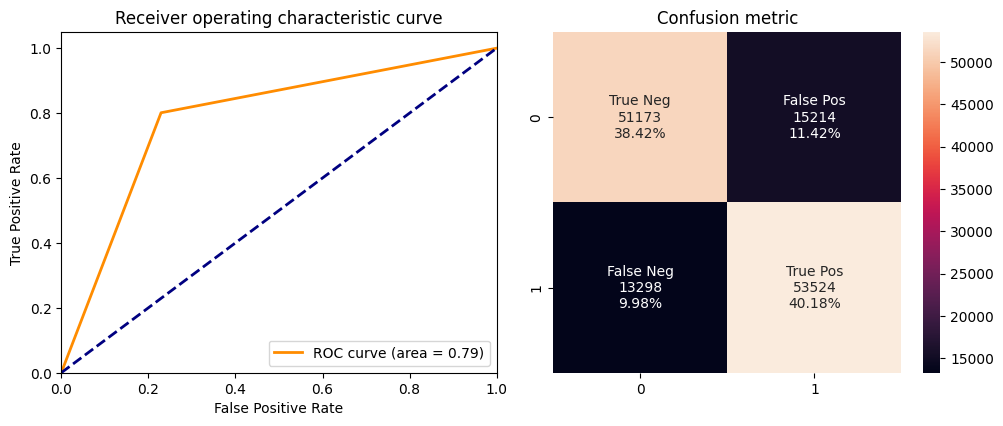

,Precision,Recall,F1,Accuracy,ROC AUC Score
0,0.78,0.8,0.79,0.79,0.79


In [14]:
from sklearn.linear_model import LogisticRegression

log_model = fittingModel("LogisticRegression" , LogisticRegression(),
                         X_train_basic, X_test_basic, y_train, y_test)

In [15]:
wrong_classified(X_test, y_test, log_model[1])

,text,label,prediction
378593,sitting wondering barbecue better quick countdown officially start wait,0,1
234331,found baby robin yardno mommie touch put woods hope finds cute opened mouth feed,0,1
1293940,tell us really feel going backforth sql compactfull mean data migration andor something else,1,0
235072,listened people ragging viola,0,1
1087348,want live vicariously,1,0
986044,go th floor official quiet floor,1,0
257760,wow laughing loud woke buahaha tears eyes difference lol cannot see background using itouch,0,1
948622,got work returned apartmentturned tv saw weather channel tell last,1,0
130547,google wave dev preview video firefox client crashed,0,1
325621,knw hv restrictions hey evryday quotlike alwaysquot inshalla spend like birthday may,0,1


# 2. NN

## Splitting into test and val

In [16]:
X = df['text']  # Features (text)
y = df['sentiment']  # Labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
 # X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### tokenization

In [18]:
textToken = [text.split() for text in X_train]

### creating embeeding model with wrod2vec

In [19]:
from gensim.models import Word2Vec
import gensim
import gensim.downloader as api
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [20]:
# WORD2VEC 
WORD2VEC_MODEL = "model2.w2v"
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [21]:
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 1024

In [22]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [23]:
w2v_model.build_vocab(textToken)

In [24]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 32581


In [25]:
%%time
w2v_model.train(textToken, total_examples=len(textToken), epochs=W2V_EPOCH)


CPU times: user 26min 7s, sys: 8 s, total: 26min 15s
Wall time: 7min 49s


(265616469, 304501536)

In [26]:
w2v_model.wv.most_similar("love")

[('adore', 0.6139412522315979),
 ('loved', 0.5440647602081299),
 ('loves', 0.539458155632019),
 ('miss', 0.48915043473243713),
 ('lovee', 0.4819703996181488),
 ('lt', 0.478708416223526),
 ('looove', 0.47375038266181946),
 ('loove', 0.46576693654060364),
 ('amazing', 0.4504588842391968),
 ('looooove', 0.4491012990474701)]

In [27]:
w2v_model.save(WORD2VEC_MODEL)

In [28]:
w2v_model = Word2Vec.load('/kaggle/input/model2/model2.w2v')

#### Tokenizer

In [29]:
from keras.preprocessing.text import Tokenizer

In [30]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 364751
CPU times: user 26.7 s, sys: 179 ms, total: 26.8 s
Wall time: 26.8 s


In [31]:
SEQUENCE_LENGTH = 300

In [32]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: user 32.7 s, sys: 772 ms, total: 33.5 s
Wall time: 33.5 s


### labels encoders

In [33]:
encoder = LabelEncoder()
encoder.fit(y_train.tolist())

y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1198873, 1)
y_test (133209, 1)


In [34]:
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (1198873, 300)
y_train (1198873, 1)

x_test (133209, 300)
y_test (133209, 1)


#### Embedding layer

In [35]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, trainable=False)

(364751, 300)


### lstm model

In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          109425300 
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 109,585,801
Trainable params: 160,501
Non-trainable params: 109,425,300
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [38]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [39]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/3
1054/1054 [==============================] - 8180s 8s/step - loss: 0.4983 - accuracy: 0.7545 - val_loss: 0.4572 - val_accuracy: 0.7839 - lr: 0.0010
Epoch 2/3
1054/1054 [==============================] - 8222s 8s/step - loss: 0.4711 - accuracy: 0.7719 - val_loss: 0.4507 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 3/3
1054/1054 [==============================] - 8217s 8s/step - loss: 0.4637 - accuracy: 0.7766 - val_loss: 0.4435 - val_accuracy: 0.7912 - lr: 0.0010
CPU times: user 23h 42min 3s, sys: 2h 9min 45s, total: 1d 1h 51min 48s
Wall time: 6h 50min 27s


In [40]:
model.save("lstm_model.h5")

In [41]:
%%time
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

131/131 [==============================] - 214s 2s/step - loss: 0.4383 - accuracy: 0.7946

ACCURACY: 0.7945784330368042
LOSS: 0.4383258521556854
CPU times: user 11min 12s, sys: 1min 46s, total: 12min 58s
Wall time: 3min 34s


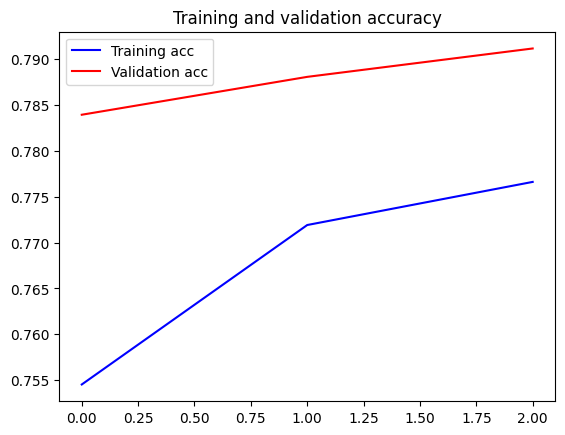

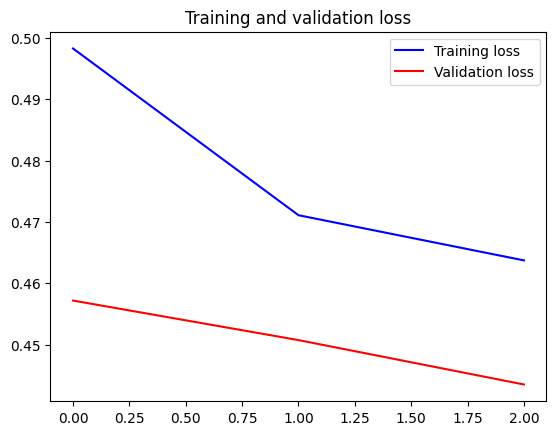

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
pred = model.predict(X_test)

4163/4163 [==============================] - 348s 83ms/step


In [44]:
pred_binary = np.where(pred > 0.5, 1, 0)

/tmp/ipykernel_20/2301599994.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/tmp/ipykernel_20/2301599994.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


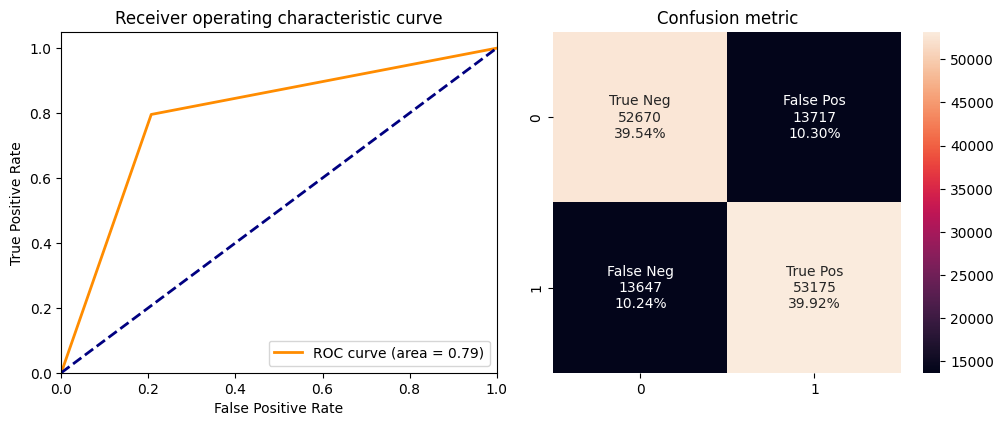

,Precision,Recall,F1,Accuracy,ROC AUC Score
0,0.79,0.8,0.8,0.79,0.79


In [45]:
AllScores = []
name = 'LSTM_model'
returnValues = [name]+metrixAndScoring(y_test, pred_binary)
AllScores.append(returnValues)
display(pd.DataFrame([[returnValues[1], returnValues[2], returnValues[3], returnValues[4], returnValues[5]]], columns=['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC Score']).round(2))


In [46]:
from tensorflow.keras.models import load_model

model = load_model("lstm_model.h5")


transformer
1. cleaner data
2. more detailed data